# Kmeans
Each digit of mnist is 28*28 pixels, then it is truncated and resized to smaller image for faster computation without losing too much information. Then, it is flattend to 1D array and scaled.

K-mean with 216 clusters accurately identifies 90% digits of validation dataset though it is **UNSUPERVISED** while having 81% homogeneity score. As shown in the plots, k-means able to identify the underlying structure of mnist dataset. 

K-mean can be useful to label a larger unlabelled dataset from clustering smaller labelled dataset.

In [1]:
#Import Libraries
import math
import mnist

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf # image processing

import sklearn as sk
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

mnist.download()
np.random.seed(42)

In [2]:
def unpad(arr, width):
    return arr[width:arr.shape[0]-width, width:arr.shape[1]-width]

def flatten_dim(dim):
    from operator import mul
    from functools import reduce
    return reduce(mul, dim)

def transform(digits, pad = None, dim = None):
    tmp = digits
    if pad is not None:
        tmp = np.array([unpad(img, pad) for img in tmp])
    if dim is not None:
        tmp = tf.constant(tmp)
        tmp = tf.image.resize(tmp, dim).numpy()
    tmp = tmp.reshape(-1, flatten_dim(tmp.shape[1:]))
    # the digit images are grayscale ranging 0 to 255 hence
    tmp = tmp / 255.0
    return tmp

def calc_all_metrics(X, true_label, pred_labels):
    from sklearn import metrics
    return {
        'homogeneity': metrics.homogeneity_score(true_label, pred_labels),
        'adjusted_rand': metrics.adjusted_rand_score(true_label, pred_labels),
        'accuracy' : metrics.accuracy_score(true_label, pred_labels),
    }

C:\Users\LEONGT~1\AppData\Local\Temp/ipykernel_14524/557602354.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


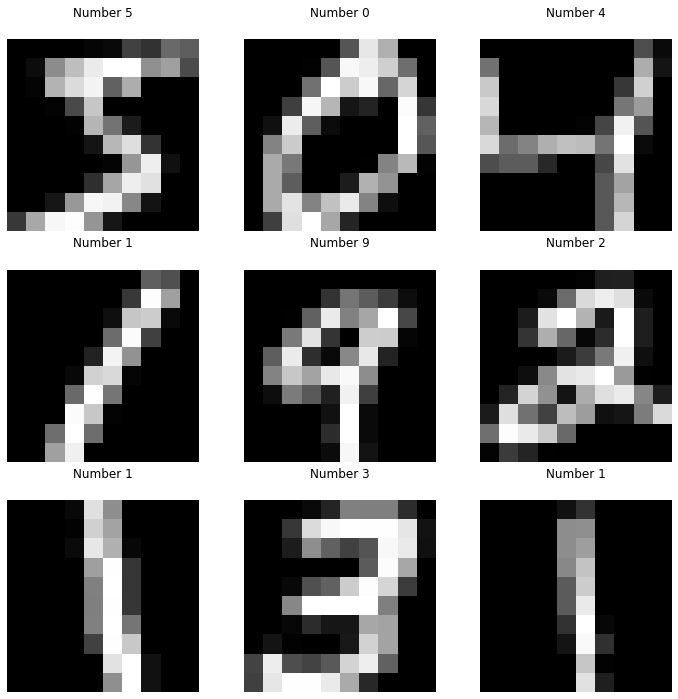

In [3]:
d = 10
digits, labels = mnist.extract_train()
test_digits, test_labels = mnist.extract_test()
digits, test_digits = tuple(transform(tmp, 4, (d,d)) for tmp in [digits, test_digits])
[tmp.shape for tmp in [digits, test_digits]]

fig, axs = plt.subplots(3, 3, figsize = (12,12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.matshow(digits[i].reshape(d,d))
    ax.axis('off')
    ax.set_title(f'Number {labels[i]}')

fig.show()

In [4]:
print(n_digits := len(np.unique(labels)))
kmeans = MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(digits), kmeans.labels_

10


(MiniBatchKMeans(n_clusters=10), array([4, 3, 0, ..., 8, 1, 6]))

In [5]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # extract points that correspond to label == i
        labels = []
        index = np.where(kmeans.labels_ == i)
        
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1: # why?
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels


def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [6]:
def calculate_metrics(X, Y, clusters):
    from sklearn.metrics import homogeneity_score, accuracy_score
    inertia_res, homogeneity_res, acc_res = [],[],[]
    
    for n_clusters in clusters:
        estimator = MiniBatchKMeans(n_clusters = n_clusters).fit(X)
    
        inertia_res.append(estimator.inertia_)    
        homogeneity_res.append(homogeneity_score(labels, estimator.labels_))
        
        # determine predicted labels
        cluster_labels = infer_cluster_labels(estimator, Y)
        predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
        
        acc_res.append(accuracy_score(Y, predicted_Y))
    return inertia_res, homogeneity_res, acc_res

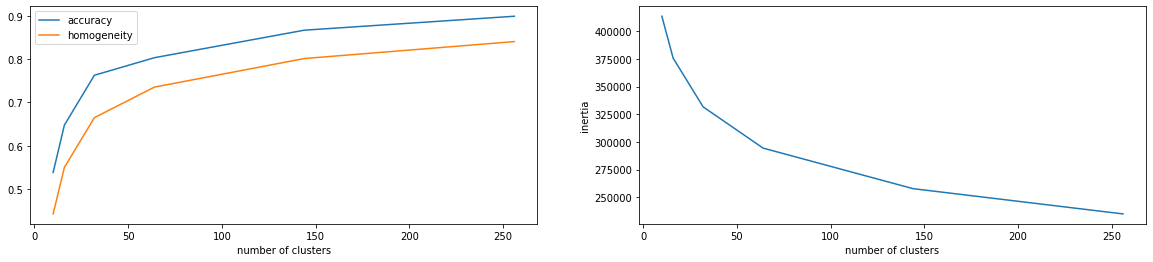

In [7]:
clusters = [10, 16, 32, 64, 144, 256]
inertia_res, homogeneity_res, acc_res = calculate_metrics(digits, labels, clusters)

fig, axs = plt.subplots(1, 2, figsize = (20,4))

axs[0].plot(clusters, acc_res, label = 'accuracy')
axs[0].plot(clusters, homogeneity_res, label = 'homogeneity')
axs[0].legend()
axs[0].set_xlabel("number of clusters")

axs[1].plot(clusters, inertia_res)
axs[1].set_ylabel("inertia")
axs[1].set_xlabel("number of clusters");

In [8]:
from sklearn import metrics
# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(digits)
cluster_labels = infer_cluster_labels(kmeans, labels)

# predict labels for testing data
test_clusters = kmeans.predict(test_digits)
predicted_labels = infer_data_labels(test_clusters, cluster_labels)
    
# calculate and print accuracy
{
    'train': metrics.accuracy_score(labels, infer_data_labels(kmeans.predict(digits), cluster_labels)),
    'validation': metrics.accuracy_score(test_labels, predicted_labels)
}

{'train': 0.8969333333333334, 'validation': 0.9026}

{'homogeneity': 0.7996909912428002,
 'adjusted_rand': 0.7958500737869081,
 'accuracy': 0.8969333333333334}

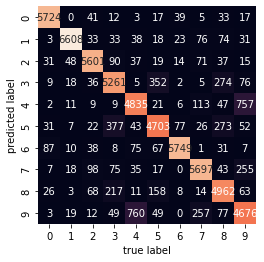

In [9]:
def plot_confusion_matrix(labels, pred_labels):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    mat = confusion_matrix(labels, pred_labels)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

train_cluster = kmeans.predict(digits)
pred_labels = infer_data_labels(train_cluster, cluster_labels)
plot_confusion_matrix(labels, pred_labels)
calc_all_metrics(digits, labels, pred_labels)

{'homogeneity': 0.8106215602591117,
 'adjusted_rand': 0.8065213993152061,
 'accuracy': 0.9026}

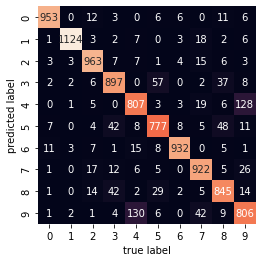

In [10]:
test_clusters = kmeans.predict(test_digits)
pred_labels = infer_data_labels(test_clusters, cluster_labels)
plot_confusion_matrix(test_labels, pred_labels)
calc_all_metrics(test_digits, test_labels, pred_labels)